<a href="https://colab.research.google.com/github/Wesley00s/Computer-Vision/blob/main/CNN_Corn_or__Maize_Leaf_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Input
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
import pathlib
import cv2
from sklearn.model_selection import train_test_split

# Dataset

In [2]:
!rm -r /content/data

In [3]:
!kaggle datasets download smaranjitghose/corn-or-maize-leaf-disease-dataset
!unzip -q corn-or-maize-leaf-disease-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
corn-or-maize-leaf-disease-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
base_dir = '/content/data'
data = pathlib.Path(base_dir)
subpaths = [path for path in data.iterdir() if path.is_dir()]

# Exploratory analysis

In [5]:
subpaths = sorted(subpaths)
total_classes = len(subpaths)
print(f'Number of classes: {total_classes}')

Number of classes: 4


In [6]:
print(f'Classes: {", ".join([path.name for path in subpaths])}')

Classes: Blight, Common_Rust, Gray_Leaf_Spot, Healthy


In [7]:
images_by_class = [len(list(path.iterdir())) for path in subpaths]
images_by_class

[1146, 1306, 574, 1162]

In [8]:
total_samples = sum(images_by_class)
print(f'Total samples: {total_samples}')

Total samples: 4188


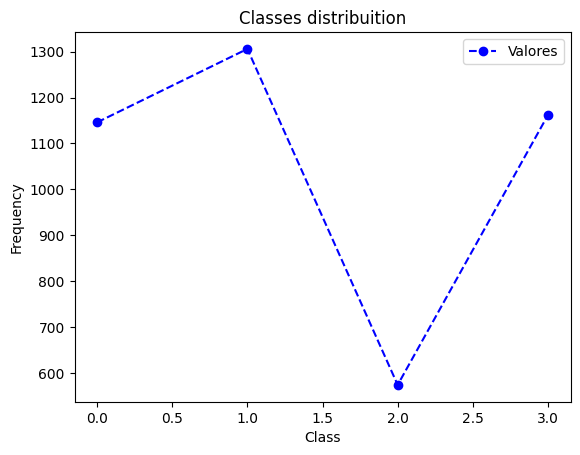

In [9]:
plt.plot(images_by_class, marker='o', linestyle='--', color='b', label='Valores')
plt.title('Classes distribuition')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [10]:
classes = [path.name for path in subpaths]
classes

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

In [11]:
class_mapping = dict((c, i) for i, c in enumerate(classes))
class_mapping

{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}

In [12]:
class_weights = {
    class_mapping[class_name]: total_samples / (total_classes * images_by_class[i])
    for i, class_name in enumerate(classes)
}

class_weights

{0: 0.9136125654450262,
 1: 0.8016845329249617,
 2: 1.82404181184669,
 3: 0.9010327022375215}

# Analysis of image dimensions and formats

In [13]:
images = [list(path.iterdir()) for path in subpaths]

In [14]:
cv2.imread(images[0][0]).shape

(776, 800, 3)

In [15]:
dimensions_set = set()

for class_images in images:
    for img_path in class_images:
        img = cv2.imread(str(img_path))
        dimensions_set.add(img.shape[:2])

if len(dimensions_set) > 1:
    print(f"Images have different dimensions: {dimensions_set}")
else:
    print(f"All images have the same dimensions: {dimensions_set.pop()}")

Images have different dimensions: {(660, 1080), (699, 525), (776, 800), (646, 379), (1200, 1600), (255, 375), (1632, 1224), (640, 640), (374, 594), (612, 450), (272, 400), (1440, 1920), (275, 417), (317, 188), (350, 374), (394, 700), (195, 500), (300, 300), (454, 239), (335, 504), (750, 1000), (443, 666), (395, 525), (339, 300), (302, 400), (268, 432), (194, 309), (1024, 650), (433, 527), (832, 672), (466, 350), (595, 900), (400, 1024), (300, 400), (341, 401), (431, 575), (378, 420), (309, 497), (711, 565), (1000, 1333), (200, 590), (487, 400), (900, 1200), (287, 384), (331, 616), (766, 400), (554, 563), (501, 612), (428, 640), (200, 300), (827, 1536), (5184, 3456), (1500, 2128), (534, 334), (450, 600), (297, 507), (3264, 1489), (679, 432), (340, 255), (257, 388), (700, 613), (287, 432), (206, 477), (338, 450), (360, 480), (2592, 1944), (1001, 751), (600, 800), (188, 575), (3264, 1836), (279, 519), (334, 400), (500, 185), (577, 1024), (400, 400), (540, 349), (628, 471), (276, 660), (19

# Visual Inspection of Images

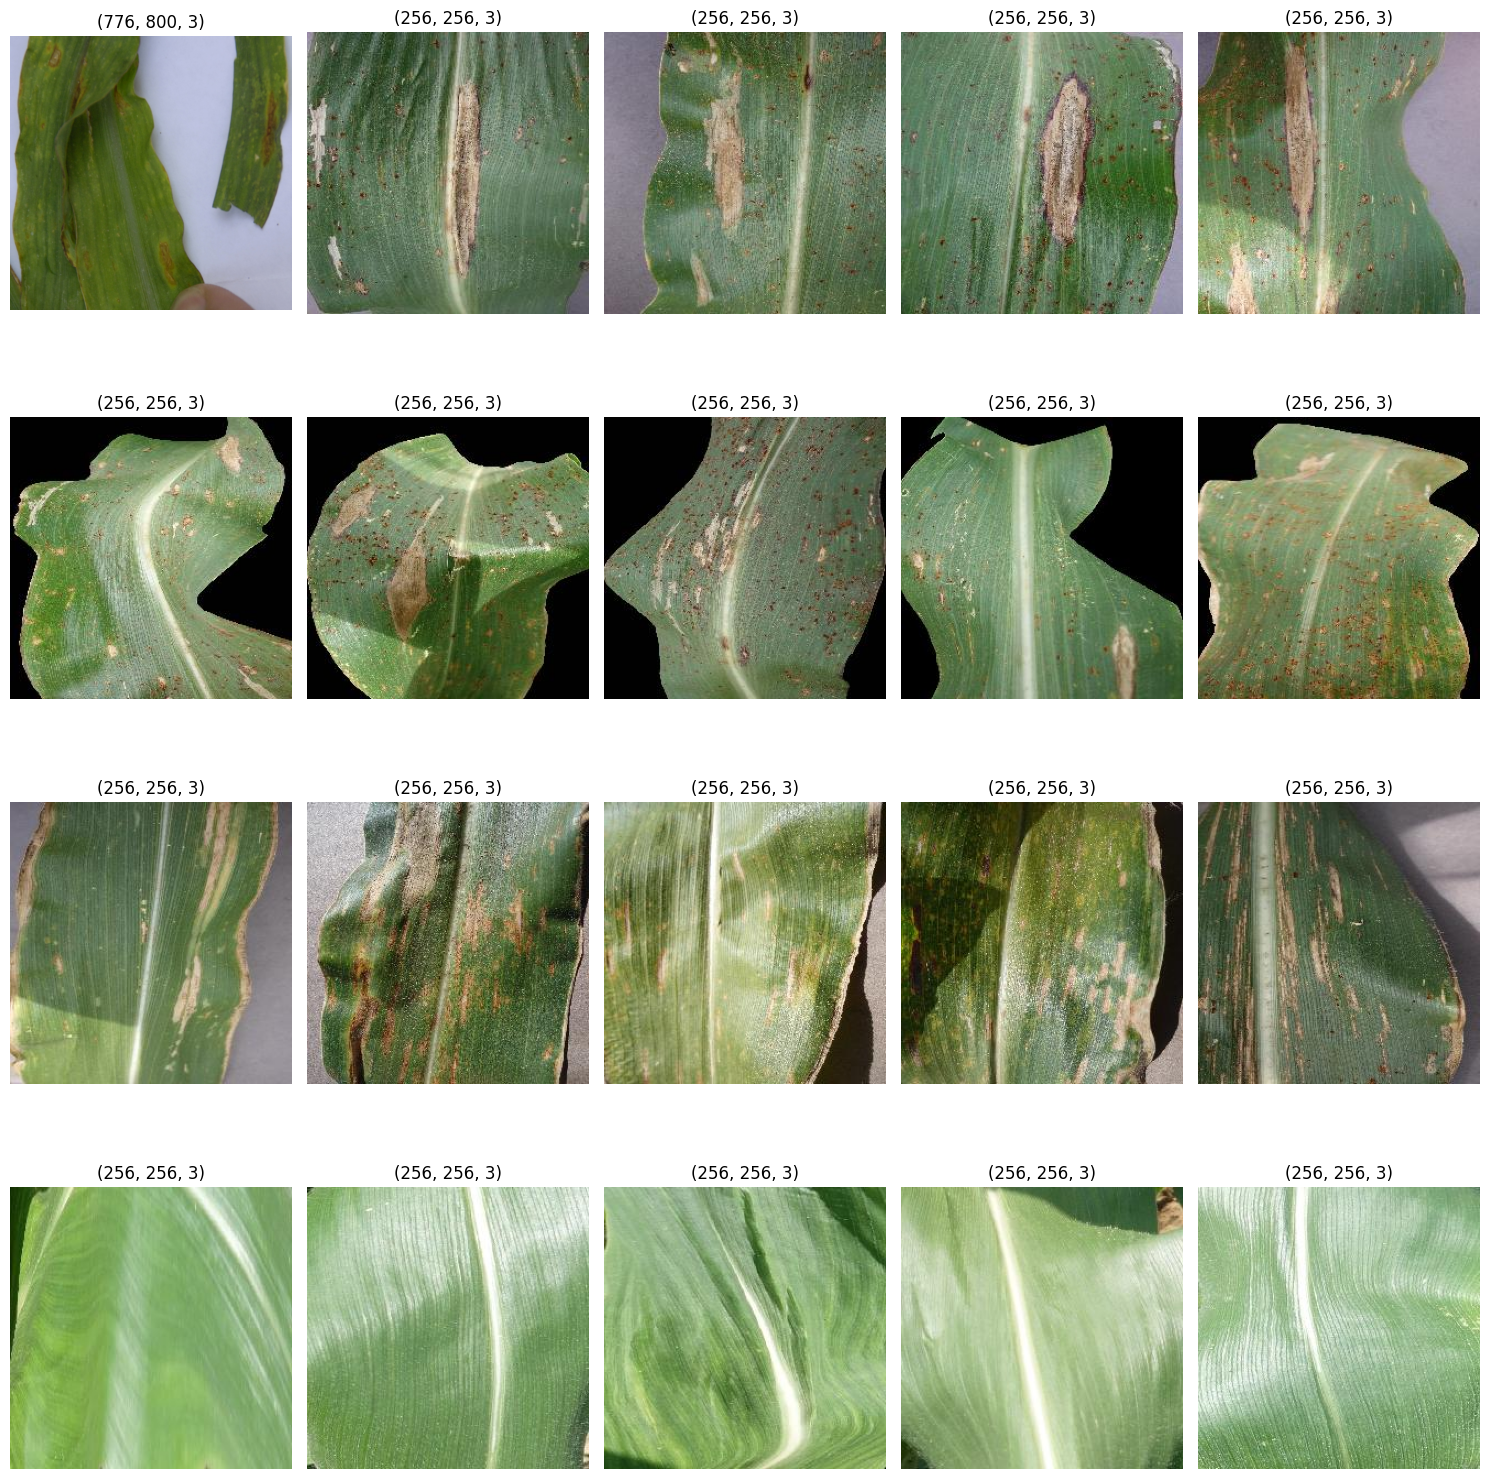

In [16]:
num_classes = len(images)
images_per_class = min(5, len(images[0]))
fig, axs = plt.subplots(num_classes, images_per_class, figsize=(15, 4 * num_classes))

for class_idx in range(num_classes):
    for img_idx in range(images_per_class):
        img_path = str(images[class_idx][img_idx])
        img = cv2.imread(img_path)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axs[class_idx, img_idx].imshow(img)
        axs[class_idx, img_idx].set_title(f"{cv2.imread(images[class_idx][img_idx]).shape}")
        axs[class_idx, img_idx].axis('off')

plt.tight_layout()
plt.show()

# Pre processing

In [17]:
width = 256
height = 256
channels = 3

In [18]:
dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/data',
    image_size=(width, height),
    batch_size=32
)

Found 4188 files belonging to 4 classes.


Convert images to np array

In [19]:
images = []
labels = []

for image, label in dataset:
    images.append(image.numpy())
    labels.append(label.numpy())

images = np.concatenate(images, axis=0)
labels = np.concatenate(labels, axis=0)

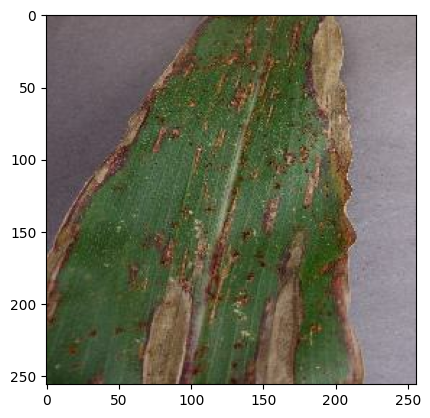

In [20]:
plt.imshow(images[0].astype('uint8'))

In [21]:
labels

array([0, 0, 1, ..., 1, 3, 2], dtype=int32)

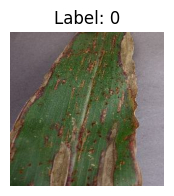

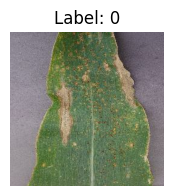

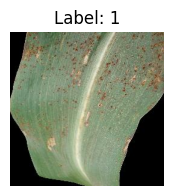

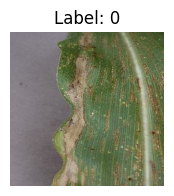

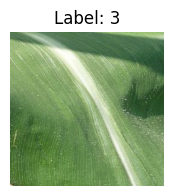

In [22]:
for i in range(5):
    plt.figure(figsize=(2, 2))
    plt.imshow(images[i].astype("uint8"))
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")
    plt.show()

# Training setup

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)

###### Standard the image values [0-1]

In [24]:
X_train

array([[[[  9.      ,  13.      ,   0.      ],
         [  8.      ,  12.      ,   0.      ],
         [  7.      ,   8.      ,   2.      ],
         ...,
         [129.      , 159.      , 123.      ],
         [133.      , 163.      , 127.      ],
         [122.      , 152.      , 116.      ]],

        [[  8.      ,  12.      ,   0.      ],
         [  7.      ,  11.      ,   0.      ],
         [  7.      ,   8.      ,   2.      ],
         ...,
         [124.      , 154.      , 118.      ],
         [128.      , 158.      , 122.      ],
         [118.      , 148.      , 112.      ]],

        [[  7.      ,  11.      ,   0.      ],
         [  7.      ,  11.      ,   0.      ],
         [  7.      ,   8.      ,   2.      ],
         ...,
         [120.      , 152.      , 113.      ],
         [124.      , 156.      , 117.      ],
         [116.      , 148.      , 109.      ]],

        ...,

        [[ 49.      ,  94.      ,  29.      ],
         [ 59.      , 104.      ,  39.      ]

In [25]:
X_train /= 255
X_test /= 255

In [26]:
X_train

array([[[[0.03529412, 0.05098039, 0.        ],
         [0.03137255, 0.04705882, 0.        ],
         [0.02745098, 0.03137255, 0.00784314],
         ...,
         [0.5058824 , 0.62352943, 0.48235294],
         [0.52156866, 0.6392157 , 0.49803922],
         [0.47843137, 0.59607846, 0.45490196]],

        [[0.03137255, 0.04705882, 0.        ],
         [0.02745098, 0.04313726, 0.        ],
         [0.02745098, 0.03137255, 0.00784314],
         ...,
         [0.4862745 , 0.6039216 , 0.4627451 ],
         [0.5019608 , 0.61960787, 0.47843137],
         [0.4627451 , 0.5803922 , 0.4392157 ]],

        [[0.02745098, 0.04313726, 0.        ],
         [0.02745098, 0.04313726, 0.        ],
         [0.02745098, 0.03137255, 0.00784314],
         ...,
         [0.47058824, 0.59607846, 0.44313726],
         [0.4862745 , 0.6117647 , 0.45882353],
         [0.45490196, 0.5803922 , 0.42745098]],

        ...,

        [[0.19215687, 0.36862746, 0.11372549],
         [0.23137255, 0.40784314, 0.15294118]

# Create neural network

In [27]:
model = Sequential()

### Add Convolutional and Pooling layers

In [28]:
model.add(Input(shape=(width, height, channels)))
model.add(Conv2D(filters=32, kernel_size=5, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'))

In [29]:
model.add(Conv2D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'))

In [30]:
model.add(Conv2D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'))

### Add flatening layer

In [31]:
model.add(Flatten())

### Add dense layer

In [32]:
model.add(Dense(units=512, activation='relu'))

### Output layer

In [33]:
model.add(Dense(units=10, activation='softmax'))

### Model Summary

In [34]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 252, 252, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 122, 122, 64)        │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 57, 57, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      51,380,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,644,490 (197.01 MB)

 Trainable params: 51,644,490 (197.01 MB)

 Non-trainable params: 0 (0.00 B)

# Compile model

In [35]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Training model

In [36]:
model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    class_weight=class_weights
);

Epoch 1/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.5214 - loss: 1.4881 - val_accuracy: 0.7709 - val_loss: 0.4730
Epoch 2/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7845 - loss: 0.5510 - val_accuracy: 0.8377 - val_loss: 0.3529
Epoch 3/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8535 - loss: 0.3974 - val_accuracy: 0.7625 - val_loss: 0.5096
Epoch 4/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8439 - loss: 0.3956 - val_accuracy: 0.8663 - val_loss: 0.3247
Epoch 5/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8793 - loss: 0.3390 - val_accuracy: 0.8377 - val_loss: 0.3997
Epoch 6/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8944 - loss: 0.2829 - val_accuracy: 0.8592 - val_loss: 0.3423
Epoch 7/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8985 - loss: 0.2675 - val_accuracy: 0.8842 - val_loss: 0.3231
Epoch 8/20
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9263 - loss: 0.2273 - val_ac

# Evaluate model

In [37]:
model.evaluate(X_test, y_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9039 - loss: 0.6291


[0.6501088738441467, 0.89737468957901]

# Metrics

In [38]:
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


### Accuracy

In [39]:
accuracy = accuracy_score(y_test, y_pred_classes)
accuracy

0.8973747016706444

### Precision

In [40]:
precision = precision_score(y_test, y_pred_classes, average="weighted")
precision

0.9019227551298297

### Recall

In [41]:
recall = recall_score(y_test, y_pred_classes, average="weighted")
recall

0.8973747016706444

### F1 Score

In [42]:
f1 = f1_score(y_test, y_pred_classes, average="weighted")
f1

0.899040959354942

### Metrics plot

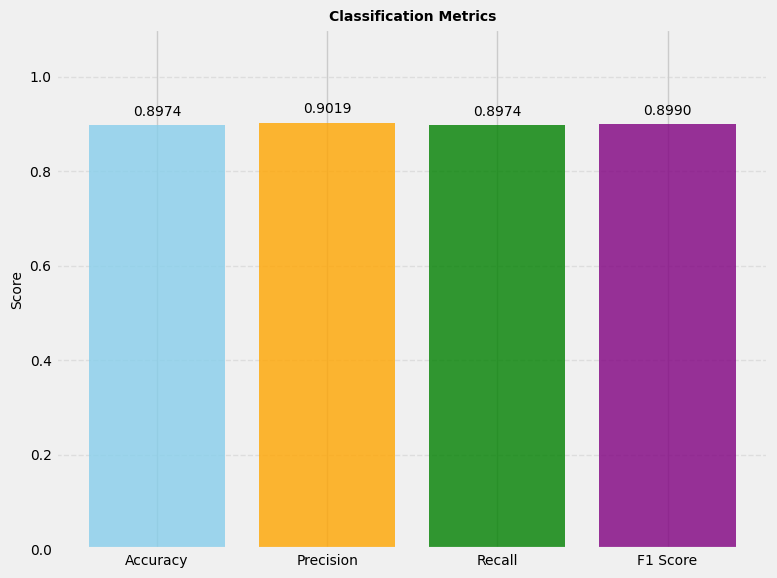

In [45]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [accuracy, precision, recall, f1]
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 6))
bars = plt.bar(metrics, scores, color=['skyblue', 'orange', 'green', 'purple'], alpha=0.8)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.4f}', ha='center', fontsize=10, color='black')

plt.ylim(0, 1.1)
plt.ylabel('Score', fontsize=10)
plt.title('Classification Metrics', fontsize=10, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

#### Confusion matrix

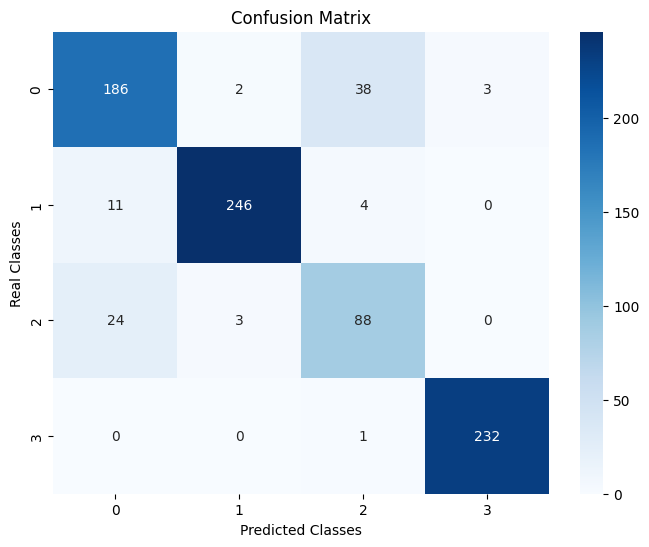

In [46]:
cm = confusion_matrix(y_test, y_pred_classes)
plt.style.use('default')
plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Classes")
plt.ylabel("Real Classes")
plt.show()